# 21.2 X-Learner

**Chapter**: 21 - Meta-Learners  
**Section**: 2 - X-Learner (Two-Stage with Propensity Weighting)  
**Facure Source**: 21-Meta-Learners.ipynb  
**Version**: 1.0.0  
**Last Validated**: 2026-01-16

---

## Table of Contents

1. [The T-Learner Problem Revisited](#1-the-t-learner-problem-revisited)
2. [X-Learner Architecture](#2-x-learner-architecture)
   - 2.1 [Stage 1: T-Learner Models](#21-stage-1-t-learner-models)
   - 2.2 [Stage 2: Imputed Effect Models](#22-stage-2-imputed-effect-models)
   - 2.3 [Propensity Score Weighting](#23-propensity-score-weighting)
3. [Implementation](#3-implementation)
4. [Why It Works](#4-why-it-works)
5. [Interview Appendix](#5-interview-appendix)
6. [References](#6-references)

---

In [1]:
# Standard imports
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm, stats,
    load_facure_data,
    set_notebook_style,
    create_tufte_figure,
    apply_tufte_style,
    TUFTE_PALETTE,
    COLORS,
)

from lightgbm import LGBMRegressor
from sklearn.linear_model import LogisticRegression

set_notebook_style()
np.random.seed(42)

print("Imports loaded successfully")

Imports loaded successfully


In [2]:
# Load data
train = load_facure_data('invest_email_biased.csv')
test = load_facure_data('invest_email_rnd.csv')

y = 'converted'
T = 'em1'
X = ['age', 'income', 'insurance', 'invested']

print(f"Training: {len(train):,} samples")
print(f"Testing: {len(test):,} samples")

Training: 15,000 samples
Testing: 15,000 samples


---

## 1. Facure's Intuition: The T-Learner Problem

> **Recall**: T-learner fails with imbalanced groups because different regularization levels create spurious heterogeneity.

The X-Learner solves this by:
1. **Imputing** treatment effects using counterfactual predictions
2. **Weighting** models by propensity score to favor reliable estimates

## 2. Formal Treatment: X-Learner Architecture

```
X-Learner (Kunzel et al. 2019) ─────────────────────────────

STAGE 1: T-Learner (same as before)
──────────────────────────────────
Control data → μ̂₀(x) = E[Y | X, T=0]
Treated data → μ̂₁(x) = E[Y | X, T=1]

STAGE 2: Imputed Effects
────────────────────────
For control units: τ̃(X, T=0) = μ̂₁(X) - Y  (what they would have gained)
For treated units: τ̃(X, T=1) = Y - μ̂₀(X)  (what they actually gained)

Fit models on these imputed effects:
  M_τ0 ≈ E[τ̃ | X, T=0]   (effect model from control imputation)
  M_τ1 ≈ E[τ̃ | X, T=1]   (effect model from treated imputation)

STAGE 3: Propensity-Weighted Combination
────────────────────────────────────────
e(x) = P(T=1 | X)  (propensity score)

τ̂(x) = e(x) · M_τ0(x) + (1-e(x)) · M_τ1(x)

↳ When treatment is rare: e(x) small → favors M_τ1 (from treated data)
↳ When treatment is common: 1-e(x) small → favors M_τ0 (from control data)
──────────────────────────────────────────────────────────────
```

### 2.1 Stage 1: T-Learner Models

In [3]:
# Stage 1: Same as T-learner
np.random.seed(123)

m0 = LGBMRegressor(max_depth=2, min_child_samples=30, n_estimators=100, verbose=-1)
m1 = LGBMRegressor(max_depth=2, min_child_samples=30, n_estimators=100, verbose=-1)

# Fit on subsets
m0.fit(train.query(f"{T}==0")[X], train.query(f"{T}==0")[y])
m1.fit(train.query(f"{T}==1")[X], train.query(f"{T}==1")[y])

# Also fit propensity score model
g = LogisticRegression(solver='lbfgs', max_iter=1000)
g.fit(train[X], train[T])

print("Stage 1 complete:")
print(f"  mu0 trained on {(train[T]==0).sum():,} control samples")
print(f"  mu1 trained on {(train[T]==1).sum():,} treated samples")
print(f"  Propensity model trained")

Stage 1 complete:
  mu0 trained on 11,630 control samples
  mu1 trained on 3,370 treated samples
  Propensity model trained


### 2.2 Stage 2: Imputed Effect Models

**Key insight**: We impute treatment effects using counterfactual predictions:

- For **control** units: $\tilde{\tau}(X, T=0) = \hat{\mu}_1(X) - Y$
  - "How much would this control unit have gained if treated?"
  - Uses the treated model to predict counterfactual

- For **treated** units: $\tilde{\tau}(X, T=1) = Y - \hat{\mu}_0(X)$
  - "How much did this treated unit actually gain vs. if untreated?"
  - Uses the control model to predict counterfactual

In [4]:
# Stage 2: Impute treatment effects

# For control: imputed effect = what they would have gotten - what they got
# For treated: imputed effect = what they got - what they would have gotten
d_train = np.where(
    train[T] == 0,
    m1.predict(train[X]) - train[y],  # Control: mu1(x) - Y
    train[y] - m0.predict(train[X])   # Treated: Y - mu0(x)
)

print("Imputed treatment effects:")
print(f"  For control units: mean={d_train[train[T]==0].mean():.4f}")
print(f"  For treated units: mean={d_train[train[T]==1].mean():.4f}")

Imputed treatment effects:
  For control units: mean=0.1078
  For treated units: mean=0.0638


In [5]:
# Fit second-stage models on imputed effects
mx0 = LGBMRegressor(max_depth=2, min_child_samples=30, n_estimators=100, verbose=-1)
mx1 = LGBMRegressor(max_depth=2, min_child_samples=30, n_estimators=100, verbose=-1)

# M_tau0: effect model trained on control imputation
mx0.fit(train.query(f"{T}==0")[X], d_train[train[T]==0])

# M_tau1: effect model trained on treated imputation
mx1.fit(train.query(f"{T}==1")[X], d_train[train[T]==1])

print("Stage 2 complete: second-stage effect models fitted")

Stage 2 complete: second-stage effect models fitted


### 2.3 Propensity Score Weighting

The final CATE combines both models, weighted by propensity:

$$\hat{\tau}(x) = \hat{e}(x) \cdot M_{\tau 0}(x) + (1 - \hat{e}(x)) \cdot M_{\tau 1}(x)$$

**Why this weighting?**

- $M_{\tau 0}$ uses treated model predictions → reliable when treated group is large
- $M_{\tau 1}$ uses control model predictions → reliable when control group is large
- Propensity $e(x)$ tells us which group is larger for units like $x$
- Weight toward the model that uses the larger group's predictions

In [6]:
def x_learner_cate(mx0, mx1, g, df, X):
    """
    Compute CATE using X-learner.
    
    tau(x) = e(x) * M_tau0(x) + (1-e(x)) * M_tau1(x)
    """
    ps = g.predict_proba(df[X])[:, 1]  # e(x) = P(T=1|X)
    
    # Weight by propensity score
    # e(x) weights M_tau0 (uses mu1 predictions)
    # (1-e(x)) weights M_tau1 (uses mu0 predictions)
    cate = ps * mx0.predict(df[X]) + (1 - ps) * mx1.predict(df[X])
    
    return cate

# Compute CATE
cate_x_train = x_learner_cate(mx0, mx1, g, train, X)
cate_x_test = x_learner_cate(mx0, mx1, g, test, X)

print(f"X-Learner CATE statistics (test set):")
print(f"  Mean:   {cate_x_test.mean():.4f}")
print(f"  Std:    {cate_x_test.std():.4f}")
print(f"  Min:    {cate_x_test.min():.4f}")
print(f"  Max:    {cate_x_test.max():.4f}")

X-Learner CATE statistics (test set):
  Mean:   0.0992
  Std:    0.0743
  Min:    -0.0939
  Max:    0.4176


---

## 3. Numeric Demonstration: Implementation

Let's put it all together in a clean class:

In [7]:
class XLearner:
    """
    X-Learner for CATE estimation.
    
    Two-stage meta-learner that addresses T-learner's
    sample imbalance problem using propensity weighting.
    
    Parameters
    ----------
    base_model : sklearn estimator
        Base model for outcome prediction (default: LGBMRegressor)
    propensity_model : sklearn classifier
        Model for propensity score (default: LogisticRegression)
    """
    
    def __init__(self, base_model=None, propensity_model=None):
        from sklearn.base import clone
        
        if base_model is None:
            base_model = LGBMRegressor(max_depth=3, n_estimators=100, verbose=-1)
        if propensity_model is None:
            propensity_model = LogisticRegression(max_iter=1000)
        
        # Stage 1 models
        self.m0 = clone(base_model)
        self.m1 = clone(base_model)
        
        # Stage 2 models
        self.mx0 = clone(base_model)
        self.mx1 = clone(base_model)
        
        # Propensity model
        self.g = clone(propensity_model)
    
    def fit(self, X, T, Y):
        """
        Fit X-learner.
        
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
        T : array-like of shape (n_samples,) - binary treatment
        Y : array-like of shape (n_samples,) - outcome
        """
        X = np.asarray(X)
        T = np.asarray(T)
        Y = np.asarray(Y)
        
        # Stage 1: T-learner
        self.m0.fit(X[T == 0], Y[T == 0])
        self.m1.fit(X[T == 1], Y[T == 1])
        
        # Propensity score
        self.g.fit(X, T)
        
        # Stage 2: Imputed effects
        d = np.where(
            T == 0,
            self.m1.predict(X) - Y,  # Control
            Y - self.m0.predict(X)   # Treated
        )
        
        self.mx0.fit(X[T == 0], d[T == 0])
        self.mx1.fit(X[T == 1], d[T == 1])
        
        return self
    
    def predict(self, X):
        """
        Predict CATE.
        
        Returns
        -------
        cate : array of shape (n_samples,)
        """
        X = np.asarray(X)
        ps = self.g.predict_proba(X)[:, 1]
        return ps * self.mx0.predict(X) + (1 - ps) * self.mx1.predict(X)

print("XLearner class defined")

XLearner class defined


In [8]:
# Test the class
xl = XLearner()
xl.fit(train[X].values, train[T].values, train[y].values)
cate_xl = xl.predict(test[X].values)

print(f"XLearner CATE: mean={cate_xl.mean():.4f}, std={cate_xl.std():.4f}")

XLearner CATE: mean=0.0959, std=0.0899


/home/brandon_behring/Claude/facure_augment/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/brandon_behring/Claude/facure_augment/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/brandon_behring/Claude/facure_augment/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/brandon_behring/Claude/facure_augment/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


---

## 4. Implementation: Why It Works

Let's demonstrate on the imbalanced simulation from notebook 01:

In [9]:
# Recreate imbalanced data
np.random.seed(42)

n = 2000
X_imb = np.random.uniform(0, 1, (n, 1))
T_imb = np.random.binomial(1, 0.1, n)  # Only 10% treated
true_cate_const = 1.0  # Constant CATE
Y_imb = np.sin(2 * np.pi * X_imb[:, 0]) + T_imb * true_cate_const + np.random.normal(0, 0.3, n)

print(f"Imbalanced data: {T_imb.sum()} treated ({T_imb.mean():.1%}), {n-T_imb.sum()} control")
print(f"True CATE = {true_cate_const} (constant!)")

Imbalanced data: 189 treated (9.4%), 1811 control
True CATE = 1.0 (constant!)


In [10]:
# Compare T-learner vs X-learner on imbalanced data

# T-learner
m0_t = LGBMRegressor(max_depth=5, n_estimators=100, verbose=-1, random_state=42)
m1_t = LGBMRegressor(max_depth=5, n_estimators=100, verbose=-1, random_state=42)
m0_t.fit(X_imb[T_imb==0], Y_imb[T_imb==0])
m1_t.fit(X_imb[T_imb==1], Y_imb[T_imb==1])
cate_t = m1_t.predict(X_imb) - m0_t.predict(X_imb)

# X-learner
xl_imb = XLearner(
    base_model=LGBMRegressor(max_depth=5, n_estimators=100, verbose=-1, random_state=42)
)
xl_imb.fit(X_imb, T_imb, Y_imb)
cate_x = xl_imb.predict(X_imb)

print(f"T-Learner: mean={cate_t.mean():.3f}, std={cate_t.std():.3f}")
print(f"X-Learner: mean={cate_x.mean():.3f}, std={cate_x.std():.3f}")
print(f"Truth:     mean={true_cate_const:.3f}, std=0.000")

/home/brandon_behring/Claude/facure_augment/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/brandon_behring/Claude/facure_augment/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/brandon_behring/Claude/facure_augment/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/brandon_behring/Claude/facure_augment/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


T-Learner: mean=1.016, std=0.148
X-Learner: mean=1.019, std=0.097
Truth:     mean=1.000, std=0.000


/home/brandon_behring/Claude/facure_augment/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/brandon_behring/Claude/facure_augment/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/home/brandon_behring/Claude/facure_augment/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/brandon_behring/Claude/facure_augment/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/brandon_behring/Claude/facure_augment/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/brandon_behring/Claude/facure_augment/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


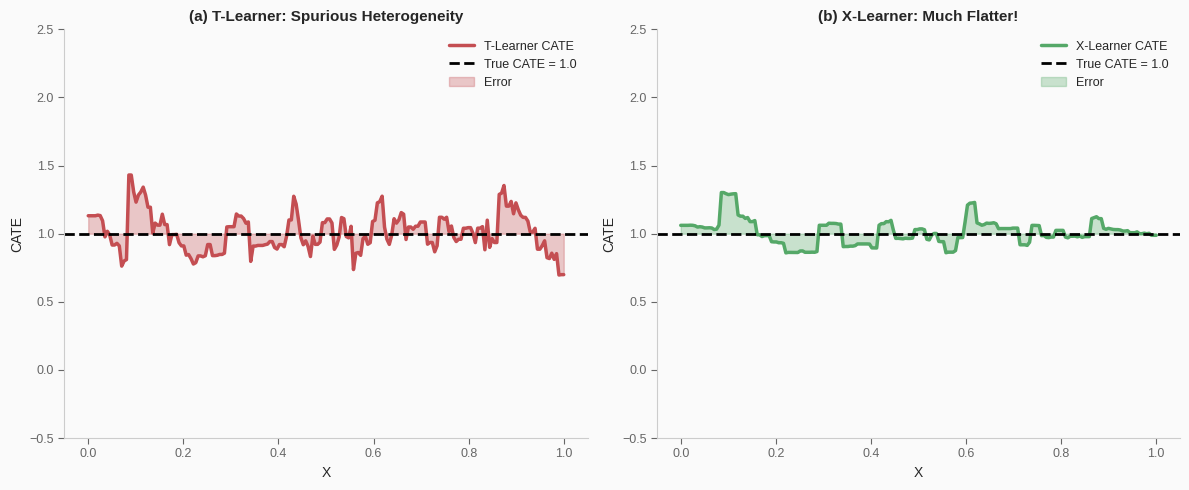


RMSE:
  T-Learner: 0.149
  X-Learner: 0.098
  Improvement: 34.0%


In [11]:
# Visualize the improvement
fig, axes = create_tufte_figure(1, 2, figsize=(12, 5))

X_grid = np.linspace(0, 1, 200).reshape(-1, 1)

# T-learner
ax = axes[0]
cate_t_grid = m1_t.predict(X_grid) - m0_t.predict(X_grid)
ax.plot(X_grid, cate_t_grid, c=COLORS['red'], lw=2.5, label='T-Learner CATE')
ax.axhline(true_cate_const, c='black', ls='--', lw=2, label=f'True CATE = {true_cate_const}')
ax.fill_between(X_grid.flatten(), true_cate_const, cate_t_grid.flatten(), 
                alpha=0.3, color=COLORS['red'], label='Error')
ax.set_xlabel('X')
ax.set_ylabel('CATE')
ax.set_title('(a) T-Learner: Spurious Heterogeneity', fontweight='bold')
ax.legend(loc='upper right', frameon=False)
ax.set_ylim(-0.5, 2.5)

# X-learner
ax = axes[1]
cate_x_grid = xl_imb.predict(X_grid)
ax.plot(X_grid, cate_x_grid, c=COLORS['green'], lw=2.5, label='X-Learner CATE')
ax.axhline(true_cate_const, c='black', ls='--', lw=2, label=f'True CATE = {true_cate_const}')
ax.fill_between(X_grid.flatten(), true_cate_const, cate_x_grid.flatten(), 
                alpha=0.3, color=COLORS['green'], label='Error')
ax.set_xlabel('X')
ax.set_ylabel('CATE')
ax.set_title('(b) X-Learner: Much Flatter!', fontweight='bold')
ax.legend(loc='upper right', frameon=False)
ax.set_ylim(-0.5, 2.5)

plt.tight_layout()
plt.show()

# Compute RMSE
rmse_t = np.sqrt(np.mean((cate_t - true_cate_const)**2))
rmse_x = np.sqrt(np.mean((cate_x - true_cate_const)**2))
print(f"\nRMSE:")
print(f"  T-Learner: {rmse_t:.3f}")
print(f"  X-Learner: {rmse_x:.3f}")
print(f"  Improvement: {(1 - rmse_x/rmse_t)*100:.1f}%")

```
Why X-Learner Works ──────────────────────────────────────────

In our imbalanced example (10% treated, 90% control):

1. μ̂₀ (control model) learns the nonlinear sin(2πx) pattern well
   (trained on 1800 samples)

2. μ̂₁ (treated model) is linear due to regularization
   (trained on only 200 samples)

3. Imputed effects for TREATED units:
   τ̃(T=1) = Y - μ̂₀(X) = [sin(x) + 1 + ε] - sin(x) ≈ 1 ✓
   → Uses the GOOD model (μ̂₀)!

4. Imputed effects for CONTROL units:
   τ̃(T=0) = μ̂₁(X) - Y = linear - sin(x) ✗
   → Uses the BAD model (μ̂₁)

5. Propensity weighting:
   e(x) ≈ 0.1 (treatment is rare)
   τ̂(x) = 0.1 * M_τ0(x) + 0.9 * M_τ1(x)
   → Heavily weights M_τ1 (from treated imputation, which is GOOD)

Result: X-learner "knows" to trust the estimate that uses
        the large control model for counterfactual prediction.
──────────────────────────────────────────────────────────────
```

---

## 5. Interview Appendix

### Practice Questions

**Q1 (Meta E6, DS)**: *"Walk me through the X-learner algorithm and explain why it handles sample imbalance better than T-learner."*

<details>
<summary>Solution</summary>

**X-Learner Algorithm (3 stages)**:

**Stage 1 (T-learner)**:
- Fit $\hat{\mu}_0(x) = E[Y|X, T=0]$ on control
- Fit $\hat{\mu}_1(x) = E[Y|X, T=1]$ on treated

**Stage 2 (Imputed effects)**:
- For control: $\tilde{\tau}_0 = \hat{\mu}_1(X) - Y$ (counterfactual gain)
- For treated: $\tilde{\tau}_1 = Y - \hat{\mu}_0(X)$ (actual gain)
- Fit $M_{\tau 0}$ on control imputed effects
- Fit $M_{\tau 1}$ on treated imputed effects

**Stage 3 (Propensity weighting)**:
- $\hat{\tau}(x) = e(x) \cdot M_{\tau 0}(x) + (1-e(x)) \cdot M_{\tau 1}(x)$

**Why it handles imbalance**:

Consider 10% treated, 90% control:
- $\hat{\mu}_0$ is accurate (many samples)
- $\hat{\mu}_1$ is regularized (few samples)
- $\tilde{\tau}_1 = Y - \hat{\mu}_0$ uses the GOOD model
- $\tilde{\tau}_0 = \hat{\mu}_1 - Y$ uses the BAD model
- Propensity $e(x) \approx 0.1$ → weights $M_{\tau 1}$ heavily
- Final estimate dominated by the reliable model!

</details>

---

**Q2 (Amazon L6)**: *"What's the intuition behind the propensity score weighting in X-learner?"*

<details>
<summary>Solution</summary>

**Intuition**: Weight toward the model trained using predictions from the larger group.

**Details**:
- $M_{\tau 0}$ is fit on imputed effects for control, which uses $\hat{\mu}_1$ predictions
- $M_{\tau 1}$ is fit on imputed effects for treated, which uses $\hat{\mu}_0$ predictions

The quality of imputed effects depends on the counterfactual model:
- If treated group is small → $\hat{\mu}_1$ is poor → $M_{\tau 0}$ unreliable
- If control group is small → $\hat{\mu}_0$ is poor → $M_{\tau 1}$ unreliable

Propensity score tells us relative group sizes:
- $e(x) = P(T=1|X)$ small → treatment rare → small treated group → trust $M_{\tau 1}$
- $e(x)$ large → treatment common → small control group → trust $M_{\tau 0}$

The weighting formula achieves exactly this:
$$\hat{\tau}(x) = \underbrace{e(x)}_{\text{small}} \cdot M_{\tau 0} + \underbrace{(1-e(x))}_{\text{large}} \cdot M_{\tau 1}$$

</details>

---

## 6. References

[^1]: Kunzel, S. R., Sekhon, J. S., Bickel, P. J., and Yu, B. (2019). Metalearners for estimating heterogeneous treatment effects using machine learning. *PNAS*, 116(10), 4156-4165.

[^2]: Facure, M. (2023). *Causal Inference for the Brave and True*. Chapter 21: "Meta-Learners."

---

**Next**: [03. Meta-Learner Comparison](./03_meta_learner_comparison.ipynb) — Evaluating and choosing between learners